<a href="https://colab.research.google.com/github/bsugerman/dip/blob/master/difimphot_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#from astropy.io import fits
import keras 
from keras.models import Model,Sequential
from keras import layers as L
from keras import callbacks as C
from keras import backend as K
import pickle
from skimage.measure import compare_ssim as ssim
import scipy.ndimage as snd
from tensorflow import boolean_mask
from tensorflow.image import ssim_multiscale
from datetime import datetime
from skimage import morphology as skm

import os
from google.colab import drive
drive.mount('/gdrive')
os.symlink('/gdrive/My Drive', '/content/gdrive')
!ls -l /content/gdrive/dip | head

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive
total 81302
-rw------- 1 root root    18720 May 29 16:36 20190529_1636.hdf5
-rw------- 1 root root    18720 May 29 16:37 20190529_1637.hdf5
-rw------- 1 root root    17088 Jul 16 20:37 20190716_2037.hdf5
-rw------- 1 root root    17088 Jul 16 20:38 20190716_2038.hdf5
-rw------- 1 root root    17088 Jul 16 20:45 20190716_2045.hdf5
-rw------- 1 root root    17088 Jul 16 20:46 20190716_2046.hdf5
-rw------- 1 root root    17088 Jul 16 20:58 20190716_2058.hdf5
-rw------- 

In [4]:
# keras layer where the image is to be fit.
class kernel_image(keras.initializers.Initializer):
    def __init__(self,image):
        self.image=image[...,np.newaxis] #np.ravel(image[...,np.newaxis])[...,np.newaxis,np.newaxis]
    def __call__(self,shape,dtype=None):
        return self.image
    
class kernel_psf(keras.initializers.Initializer):
    def __init__(self,psf):
        self.psf=psf #image[...,np.newaxis] 
    def __call__(self,shape,dtype=None):
        return self.image
    

class Image2D(L.Layer):
    def __init__(self,init_image,**kwargs):
        if 'name' not in kwargs:
            kwargs['name']='Image2D'
        self.init_image=init_image
        super(Image2D, self).__init__(**kwargs)
        
    def build(self,input_shape):
        # Create a trainable weight variable for this layer.
        assert len(input_shape)>=2
        self.kernel = self.add_weight(name='kernel', 
                                      shape=self.init_image.shape,
                                      initializer=kernel_image(self.init_image),
                                      trainable=True)
        super(Image2D, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        return x + self.kernel 

    def compute_output_shape(self, input_shape):
        return input_shape

'''# sample to convolve image
img_shape=(21,32)
input_shape=(1,)+img_shape
init_image=np.arange(np.prod(img_shape)).reshape(img_shape).astype(np.float32)
output_image=input_image*2 # just to see if scale factor comes out right
z0 = L.Input(shape=input_shape)
x=Image2D()(z0)
x=L.Conv2D(filters=3,kernel_size=1,padding='same',use_bias=False,data_format='channels_first')(x)
model= keras.models.Model(inputs=[z0], outputs=x)
opt=keras.optimizers.Adam(lr=0.1,decay=0.01)
model.compile(loss='mae', optimizer=opt)
history=model.fit([init_image[np.newaxis,np.newaxis,...]],[[output_image]],
                  epochs=100,batch_size=1)
'''

"# sample to convolve image\nimg_shape=(21,32)\ninput_shape=(1,)+img_shape\ninit_image=np.arange(np.prod(img_shape)).reshape(img_shape).astype(np.float32)\noutput_image=input_image*2 # just to see if scale factor comes out right\nz0 = L.Input(shape=input_shape)\nx=Image2D()(z0)\nx=L.Conv2D(filters=3,kernel_size=1,padding='same',use_bias=False,data_format='channels_first')(x)\nmodel= keras.models.Model(inputs=[z0], outputs=x)\nopt=keras.optimizers.Adam(lr=0.1,decay=0.01)\nmodel.compile(loss='mae', optimizer=opt)\nhistory=model.fit([init_image[np.newaxis,np.newaxis,...]],[[output_image]],\n                  epochs=100,batch_size=1)\n"

In [0]:
# fits specific functions
def imload(fits_file,return_headers=False):
    hdul = fits.open(fits_file)
    image = hdul[0].data
    if return_headers:
        return image,hdul[0].header
    else:
        return image

from skimage import morphology

def clean_mask(mask,biggest_hole=25,biggest_sep=2,smooth_radius=2):
    tmp=skm.remove_small_holes(mask,biggest_hole,biggest_sep)
    tmp=skm.binary_erosion(tmp,skm.disk(smooth_radius))
    return skm.remove_small_objects(tmp,biggest_hole,biggest_sep)
  
def edgemask(image,edge=0,min=None,max=None,
             biggest_hole=25,biggest_sep=2,smooth_radius=2):
    x=np.squeeze(image)
    markers=np.ones_like(x)+1
    markers[x==edge]=1 # mask out constant bdy value
    segmentation=morphology.watershed(x,markers)
    #return segmentation
    mask=(segmentation-1).astype(bool) # mask is 0==bad, 1==good
    #apply opening to get rid of the streaks
    mask=skm.binary_opening(mask,skm.disk(6))

    markers=np.ones_like(x).astype(bool)
    if max is not None:
        markers[x>max]=False # mask out high values
    if min is not None:
        markers[x<min]=False # mask out high values
    mask *= markers
    return clean_mask(mask,biggest_hole,biggest_sep,smooth_radius)


def maskmult(inp_mask,ref_mask,biggest_hole=25,biggest_sep=2,smooth_radius=2):
    return clean_mask(inp_mask*ref_mask,biggest_hole,biggest_sep,smooth_radius)

def odd(x):
    y=int(x)
    if np.mod(y,2):
       return y
    return y+1
  
def Gaussian(x,sigma):
    return np.exp(-x**2/sigma**2)

def delta(shape,dtype="float32"):
    '''
    kernel initializer that is a delta function at center
    '''
    base=np.zeros(shape,dtype=dtype)
    base[shape[0]//2,shape[1]//2,0,0] = 1.
    return K.variable(base,dtype=dtype)  

def kcube(shape,dtype="float32"):
    '''
    kernel initializer that looks somewhat like a psf-matching kernel
    '''
    px=shape[0]
    d=int((px-1.)/2.)
    x, y = np.meshgrid(np.linspace(-d,d,px), np.linspace(-d,d,px))
    r = np.sqrt(x*x+y*y)
    base=0.1*np.cos(2*np.pi*r/2.)*np.exp(-2.*r/d) #cong(r,2.,5)
    base+=0.6*Gaussian(r,1.4)
    #plt.imshow(base); plt.show()
    return K.variable(base[...,np.newaxis,np.newaxis],dtype=dtype)  

#def ssim(y_true, y_pred):
#    return mse(y_true, y_pred) + alpha * gse(y_true, y_pred)

class keras_masked_logcosh:
  from tensorflow import boolean_mask
  def __init__(self,mask,expand=3):
    self.__name__='kmlogcosh'
    self.masked = mask is not None
    # grow the mask edges by a few pix to ignore edge effects
    if self.masked:
        m=skm.binary_erosion(mask,skm.disk(expand))
        self.mask=K.variable(m[np.newaxis,...],dtype="bool")

  def __call__(self, y_true, y_pred):
    if self.masked:
        masked_pred=boolean_mask(y_pred,self.mask)
        masked_true=boolean_mask(y_true,self.mask)
        return keras.losses.logcosh(masked_true,masked_pred)

    else:
        return keras.losses.logcosh(y_true,y_pred)
    #print(K.eval(K.sum(masked_pred)))

class keras_masked_mae:
  from tensorflow import boolean_mask
  def __init__(self,mask,expand=3):
    self.__name__='kmmae'
    self.masked = mask is not None
    if self.masked:    
        # grow the mask edges by a few pix to ignore edge effects
        m=skm.binary_erosion(mask,skm.disk(expand))
        self.mask=K.variable(m[np.newaxis,...],dtype="bool")

  def __call__(self, y_true, y_pred):
    if self.masked:
        masked_pred=boolean_mask(y_pred,self.mask)
        masked_true=boolean_mask(y_true,self.mask)
        return K.mean(K.abs(masked_pred-masked_true))
    else:
        return K.mean(K.abs(y_pred-y_true))
  
class keras_masked_mape:
  from tensorflow import boolean_mask
  def __init__(self,mask,expand=3):
    self.__name__='kmmape'
    self.masked = mask is not None
    if self.masked:    
        # grow the mask edges by a few pix to ignore edge effects
        m=skm.binary_erosion(mask,skm.disk(expand))
        self.mask=K.variable(m[np.newaxis,...],dtype="bool")

  def __call__(self, y_true, y_pred):
    if self.masked:
        masked_pred=boolean_mask(y_pred,self.mask)
        masked_true=boolean_mask(y_true,self.mask)
        #print(K.eval(K.sum(masked_pred)))

        return 100.*K.mean(K.abs(masked_pred-masked_true)/(masked_true+K.epsilon()))
    else:
        return 100.*K.mean(K.abs(y_pred-y_true)/(y_true+K.epsilon()))

class keras_masked_msssim:
  '''
  There is literature () and my own experimentation to show that
  the combination of MSSSIM and L1 (MAE) does the best fit. It is slow
  however and it would be nice to find ways to speed this up for 
  production use. Perhaps use just MAE to find a rough first guess and 
  then turn on both to finish?
  
  tf.image.ssim_multiscale(
    img1,
    img2,
    max_val,
    power_factors=_MSSSIM_WEIGHTS,
    filter_size=11,
    filter_sigma=1.5,
    k1=0.01,
    k2=0.03
    )

    Defined in python/ops/image_ops_impl.py.

    This function assumes that img1 and img2 are image batches, i.e. the last 
    three dimensions are [height, width, channels].

    Note: The true SSIM is only defined on grayscale. This function does not 
    perform any colorspace transform. (If input is already YUV, then it will 
    compute YUV SSIM average.)
    Original paper: Wang, Zhou, Eero P. Simoncelli, and Alan C. Bovik. 
    "Multiscale structural similarity for image quality assessment." 
    Signals, Systems and Computers, 2004.

    Arguments:
    img1: First image batch.
    img2: Second image batch. Must have the same rank as img1.
    max_val: The dynamic range of the images (i.e., the difference between 
      the maximum the and minimum allowed values).
    power_factors: Iterable of weights for each of the scales. The number of 
      scales used is the length of the list. Index 0 is the unscaled resolution's 
      weight and each increasing scale corresponds to the image being downsampled 
      by 2. Defaults to (0.0448, 0.2856, 0.3001, 0.2363, 0.1333), which are the 
      values obtained in the original paper.
    filter_size: Default value 11 (size of gaussian filter).
    filter_sigma: Default value 1.5 (width of gaussian filter).
    k1: Default value 0.01
    k2: Default value 0.03 (SSIM is less sensitivity to K2 for lower values, 
      so it would be better if we taken the values in range of 0< K2 <0.4).

  '''
  from tensorflow import boolean_mask
  from tensorflow.image import ssim_multiscale
  def __init__(self,mask,expand=3,l1=1.,
               power_factors=[0.1,0.45,0.45],
               filter_size=9):
    self.__name__='kmsssim'
    self.mask = mask is not None
    self.l1=l1
    self.pf=power_factors
    self.fs=filter_size
    if self.mask:
        # grow the mask edges by a few pix to ignore edge effects
        m=skm.binary_erosion(mask,skm.disk(expand))
        self.mask4=K.variable(m[np.newaxis,...,np.newaxis],dtype="float32")
        self.mask3=K.variable(m[np.newaxis,...],dtype='bool')


  def __call__(self, y_true, y_pred):
    if self.mask:
        masked_pred=y_pred*self.mask4
        masked_true=y_true*self.mask4
        masked_msssim=1.-(ssim_multiscale(masked_pred,masked_true,
                                          K.max(masked_true)-K.min(masked_true),
                                          power_factors=self.pf,
                                          filter_size=self.fs))

        masked_pred=boolean_mask(y_pred,self.mask3)
        masked_true=boolean_mask(y_true,self.mask3)
        masked_l1=K.mean(K.abs(masked_pred-masked_true)) # MAE
        return masked_msssim + self.l1*masked_l1
    else:
        msssim=1.-(ssim_multiscale(y_pred,y_true,
                                   K.max(y_true)-K.min(y_true),
                                   power_factors=self.pf,
                                   filter_size=self.fs))
        l1=K.mean(K.abs(y_pred-y_true)) # MAE
        return msssim + self.l1*l1
         
class keras_msssim:
  '''
  There is literature () and my own experimentation to show that
  the combination of MSSSIM and L1 (MAE) does the best fit. It is slow
  however and it would be nice to find ways to speed this up for 
  production use. Perhaps use just MAE to find a rough first guess and 
  then turn on both to finish?
  '''
  from tensorflow import boolean_mask
  from tensorflow.image import ssim_multiscale
  def __init__(self,l1=1.):
    self.__name__='kmsssim'
    self.l1=l1

  def __call__(self, y_true, y_pred):
    msssim=1.-(ssim_multiscale(y_pred,y_true,K.max(y_true)))
    l1=K.mean(K.abs(y_pred-y_true)) # MAE
    return msssim + self.l1*l1

class msssim_l1():
    '''
    There is literature () and my own experimentation to show that
    the combination of MSSSIM and L1 (MAE) does the best fit. It is slow
    however and it would be nice to find ways to speed this up for 
    production use. Perhaps use just MAE to find a rough first guess and 
    then turn on both to finish?
    '''
    def __init__(self,image,l1=1.):
        _MSSSIM_WEIGHTS = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)
        self.__name__='msssim_l1'
        min_dim=np.min(image.shape[:2])
        m=1+np.min((4,int(np.floor(np.log(min_dim/11.)/np.log(2.)))))
        assert (m>0),"Low-Res Image must have dimensions greater than 11 pix on a side"
        self.weights=_MSSSIM_WEIGHTS[:m]/np.sum(_MSSSIM_WEIGHTS[:m])
        self.l1=l1

    def __call__(self, y_true, y_pred):
        msssim=(1.-(ssim_multiscale(y_pred,y_true,K.max(y_true)-K.min(y_true),
                                   power_factors=self.weights)))
        l1=self.l1*K.mean(K.abs(y_pred-y_true))  #K.sum(msssim)
        return l1+msssim
    
class msssim_logcosh():
    '''
    Custom loss function combining the MS-SSIM and logcosh between two images. 
    
    Input:
      image (array/tensor): Upon init, feed in the y_true image stack/tensor so the msssim 
        can figure out the right combination of weights to use
      alpha (float): How much of logcosh() to add to mssssim()
      
    There is literature () and my own experimentation to show that
    the combination of MSSSIM and L1 (MAE) does the best fit. I think
    logcosh may work a little better because the derivatives are more straightforward
    and large excursions don't carry quite as much weight. 
    '''
    def __init__(self,image,alpha=1.):
        _MSSSIM_WEIGHTS = (0.0448, 0.2856, 0.3001, 0.2363, 0.1333)
        self.__name__='msssim_logcosh'
        min_dim=np.min(image.shape[:2])
        m=1+np.min((4,int(np.floor(np.log(min_dim/11.)/np.log(2.)))))
        assert (m>0),"Low-Res Image must have dimensions greater than 11 pix on a side"
        self.weights=_MSSSIM_WEIGHTS[:m]/np.sum(_MSSSIM_WEIGHTS[:m])
        self.alpha=alpha

    def __call__(self, y_true, y_pred):
        msssim=(1.-(ssim_multiscale(y_pred,y_true,K.max(y_true)-K.min(y_true),
                                   power_factors=self.weights)))
        l=self.alpha*keras.losses.logcosh(y_true,y_pred)
        return l+msssim
    
 

from keras.callbacks import Callback
class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983

    Edited by BKS to only updat LR after each epoch, not batch
    '''
    def __init__(self,
                 steps_per_epoch,
                 verbose=False,
                 min_lr=1.e-2,
                 max_lr=1.e-5,
                 lr_decay=1,
                 cycle_length=10,
                 max_steps=np.inf,
                 mult_factor=1.5):

        self.verbose=verbose
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = 1. # steps_per_epoch (BKS)

        self.cycle_length = cycle_length
        self.max_steps = max_steps
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)
        self.best_weights = self.model.get_weights()

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        return # BKS
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        
        self.batch_since_restart += 1
      
        if epoch == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.cycle_length = np.min((self.cycle_length,self.max_steps))
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()
        K.set_value(self.model.optimizer.lr, self.clr())
        if self.verbose:
            print ("new lr: {:.4g}".format(K.get_value(self.model.optimizer.lr)))

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)

#
class ELRScheduler(Callback):
    '''exponential annealing learning rate scheduler with periodic restarts.
    # Usage
        ```python
            schedule = ELRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```
    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.
    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983

    Edited by BKS to only update LR after each epoch, not batch
    '''
    def __init__(self,
                 steps_per_epoch,
                 verbose=False,
                 min_lr=1.e-2,
                 max_lr=1.e-5,
                 lr_decay=1,
                 cycle_length=10,
                 max_steps=np.inf,
                 mult_factor=1.5,
                 dwell=2,):

        self.verbose=verbose
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay
        self.dwell=2

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = 1. # steps_per_epoch (BKS)

        self.cycle_length = cycle_length
        self.max_steps = max_steps
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fac=self.batch_since_restart - self.batch_since_restart%self.dwell
        fraction_to_restart = ((fac-1.) / 
            (self.steps_per_epoch * (self.cycle_length-1.)))
        lr = self.max_lr * (self.min_lr/self.max_lr)**fraction_to_restart
        #lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.max_lr)
        #self.best_weights = self.model.get_weights()


    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        return # BKS
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        K.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        
        self.batch_since_restart += 1.
      
        if epoch == self.next_restart:
            self.batch_since_restart = 1
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.cycle_length = np.min((self.cycle_length,self.max_steps))
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.min_lr *= np.sqrt(self.lr_decay)
            #self.best_weights = self.model.get_weights()
        K.set_value(self.model.optimizer.lr, self.clr())
        if self.verbose:
            print ("cycle step: {:.0f}, new lr: {:.4g}".format(
                self.batch_since_restart,K.get_value(self.model.optimizer.lr)))

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        #self.model.set_weights(self.best_weights)
        pass




def masked_mae(y_true,y_pred,mask):
  tmp=np.squeeze(np.abs(y_true-y_pred))
  return np.mean(tmp[mask])
def masked_mape(y_true,y_pred,mask):
  tmp=np.squeeze(np.abs((y_true-y_pred)/(y_true+1.e-10)))
  return 100.*np.mean(tmp[mask])
def masked_mse(y_true,y_pred,mask):
  tmp=np.squeeze(np.square(y_true-y_pred))
  return np.mean(tmp[mask])

  

In [0]:
 def subsec(image):
  return image#[200:400,300:500]

def norm(image):
    return (image-image.min())/(image.max()-image.min())


def plot(model,input,reference,mask=1,iraf_dimage=None,flip=False):
    inp=norm(input)
    ref=norm(reference)
 
    simage=mask*(np.squeeze(inp)-np.squeeze(ref))
    if flip:
        x=model.predict(ref[np.newaxis,...]) #.astype(float)      
        dimage=mask*(np.squeeze(inp)-np.squeeze(x))
        print('MAE: ', masked_mae(x,inp,mask),masked_mae(ref,inp,mask))
        print('MAPE:', masked_mape(x,inp,mask),masked_mape(ref,inp,mask))
        print('SSIM:', ssim(np.squeeze(inp)*mask,np.squeeze(x)*mask,3),
             ssim(np.squeeze(inp)*mask,np.squeeze(ref)*mask,3))
    else:
        x=model.predict(inp[np.newaxis,...]) #.astype(float)
        dimage=mask*(np.squeeze(x)-np.squeeze(ref))
        print('MAE: ', masked_mae(ref,x,mask),masked_mae(ref,inp,mask))
        print('MAPE:', masked_mape(ref,x,mask),masked_mape(ref,inp,mask))
        print('SSIM:', ssim(np.squeeze(x)*mask,np.squeeze(ref)*mask,3),
             ssim(np.squeeze(inp)*mask,np.squeeze(ref)*mask,3))
    if iraf_dimage is not None:
      print('MAE of iraf_dimage: ',np.mean(np.abs(iraf_dimage[mask])))
    
    fig=plt.figure(figsize=(15,8))
    ax=plt.subplot(2,3,1)
    plt.imshow(subsec(np.squeeze(inp)*mask),cmap='gray' ,vmin=-0.2,vmax=1)
    plt.title('Input image $I$')
    plt.colorbar()
    ax=plt.subplot(2,3,2)
    plt.imshow(subsec(np.squeeze(ref)*mask),cmap='gray' ,vmin=-0.2,vmax=1)
    plt.title('Reference image $R$')
    plt.colorbar()
    #ax=plt.subplot(2,4,3)
    #plt.imshow(subsec(np.squeeze(inp/(ref+1.e-6))*mask),cmap='gray')# ,vmin=0.5,vmax=1.5)
    #plt.title('Ratio $I/R$ ')
    #plt.colorbar()              
    ax=plt.subplot(2,3,3)
    if iraf_dimage is not None:
        plt.imshow(subsec(np.squeeze(iraf_dimage)*mask),cmap='gray',vmin=-0.25,vmax=.25)
        plt.title('IRAF $K*I-R$')
    else:      
        plt.imshow(subsec(simage),cmap='gray' ,vmin=-0.25,vmax=.25)
        plt.title('Subtraction $I-R$')

    plt.colorbar()
    

    ax=plt.subplot(2,3,4)
    plt.imshow(subsec(np.squeeze(x)*mask),cmap='gray' ,vmin=-0.2,vmax=1)
    plt.title('PSF-Matched Input image $K*I$')
    plt.colorbar()
    ax=plt.subplot(2,3,5)
    plt.imshow(subsec(np.squeeze(ref)*mask),cmap='gray' ,vmin=-0.2,vmax=1)
    plt.title('Reference image $R$')
    plt.colorbar()
    #ax=plt.subplot(2,4,7)
    #plt.imshow(subsec(np.squeeze(x/(inp+1.e-6))*mask),cmap='gray')# ,vmin=0.5,vmax=1.5)
    #plt.title('Ratio $(K*I)/I$ ')
    #plt.colorbar()
    ax=plt.subplot(2,3,6)
    plt.imshow(subsec(dimage),cmap='gray',vmin=-0.25,vmax=.25)
    plt.title('PSF-matched difference $(K*I)-R$')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    plt.plot(model.history.history['loss'],label='loss')  
    plt.plot(model.history.history['val_loss'],label='val_loss')
    plt.yscale('log')
    plt.legend()
    plt.show()
    
    w=model.get_weights()
    k=np.squeeze(w[0])
    plt.imshow(k)
    plt.colorbar()


In [0]:
def fitModel(model,inp,ref,mask=None,
             batch_size=32,epochs=1024,name=None,
             metric='ssim',verbose=False,optimizer='adam',
             reduce_patience=64,stop_patience=392,
             lr=0.01,decay=10.**-0.333,min_lr=1.e-6,
             warm_start=False,l1=1., compile_only=False,
             ):
    starttime=datetime.now()
    # N.B. don't use bias if using batchnorm; batchnorm already biases.
    # first compile the model
    if metric=='ssim':    
        #from keras_contrib.losses.dssim import DSSIMObjective 
        loss=keras_masked_msssim(mask,l1=l1)
    elif metric=='kmmape':
        loss=keras_masked_mape(mask)
    elif metric=='kmmae':
        loss=keras_masked_mae(mask)
    elif metric=='logcosh':
        loss=keras_masked_logcosh(mask)
    else:
        loss=metric
    fit_metrics=[] #'mse','mae','mape']
    if not warm_start:
        if optimizer=='adam':
            adam=keras.optimizers.Adam(lr)# ,decay=decay)
        elif optimizer=='nadam':
            adam=keras.optimizers.Nadam(lr)
        elif optimizer=='rmsprop':
            adam=keras.optimizers.RMSprop(lr) #,decay=decay)
        elif optimizer=='sgd':
            adam=keras.optimizers.SGD(lr=lr,momentum=0.9,nesterov=True) 
        model.compile(optimizer=adam,\
                      loss=loss,\
                      metrics=fit_metrics
        )
        if verbose:
            print(model.summary())
    if compile_only:
        return model
    base='/content/gdrive/dip/'

    if name is None:
        filepath="{}/{}.hdf5".format(base,datetime.now().strftime('%Y%m%d_%H%M'))
    else:
        filepath="{}/{}_{}.hdf5".format(base,name,datetime.now().strftime('%Y%m%d_%H%M'))
    if not os.path.isdir(base):
        os.mkdir(base)
    #name='{}/{}_'.format)
    
    monitor='val_loss'
    
    stop=C.EarlyStopping(monitor=monitor,patience=stop_patience,verbose=1,\
                             mode='min') # ,baseline=0.9)
    
    checkpoint = C.ModelCheckpoint(filepath, monitor=monitor, \
                                   verbose=1*verbose, save_best_only=True, \
                                   save_weights_only=True, mode='min')
    # skip for now
    if reduce_patience>0:
        #steps=np.ceil(len(np.ravel(inp))/batch_size)
        reduce_lr=ELRScheduler(1,verbose=verbose,
                                max_lr=lr,min_lr=min_lr,
                                lr_decay=0.98,mult_factor=1.33,
                                cycle_length=reduce_patience) 
        '''
        reduce_lr = C.ReduceLROnPlateau(monitor=monitor, factor=decay,
                              patience=reduce_patience, mode='min',
                              min_lr=min_lr,verbose=1)
        
        '''
        callbacks = [stop,reduce_lr,checkpoint]
    else:
        callbacks = [stop,checkpoint]

    history=model.fit([inp],[ref],verbose=1*verbose,\
                  batch_size=batch_size,validation_data=([inp],[ref]),\
                  epochs=epochs,\
                  callbacks=callbacks)
    #for i in model.history.history.iteritems():
    #    print (i[0],i[1][-1])
    model.load_weights(filepath)
    print("Model {} took {} to run".format(filepath,datetime.now()-starttime))
    return model

 

In [0]:
def psfmatch(imshape,w=17,nsub=1,mask=None,deepest=False,
             bias=True,
             BatchNormalization=False,
             kernel_init=True):
    '''
    This converges slowly but I'm able to reach very good results
    if bias=True, nonlinear=False, batchnorm=True, iters=1, dropout=0.
    '''
    # "read in" input image
    inp=L.Input(shape=imshape)
    x = L.Lambda(lambda y: K.cast(y,"float32"))(inp)
    if mask is not None: # mask is 0 or 1 for ignore/keep
        k=K.variable(mask[np.newaxis,...,np.newaxis],dtype="float32")
        x=L.Lambda(lambda y: y*k)(x)
        
    if kernel_init:
        kinit=kcube
    else:
        kinit=delta
 
    jy=imshape[0]
    ix=imshape[1]
    dp=int((w-1.)/2.)
    dx=int(np.ceil(float(ix)/nsub))
    dy=int(np.ceil(float(jy)/nsub))
          
    # "clip" out windows by just masking everything else, convolve, then
    # store in a list. windows are larger than needed to avoid edge effects
    subsecs=[]
    for i in range(0,ix,dx):
        # masking window large enough for edge region
        i1=np.clip(i-dp,0,ix)
        i2=np.clip(i+dx+dp,0,ix)
        for j in range(0,jy,dy):
            # masking window extra-large for edge region
            j1=np.clip(j-dp,0,jy)
            j2=np.clip(j+dy+dp,0,jy)
            # make mask
            submask=np.zeros(imshape)[np.newaxis,...]
            submask[:,j1:j2,i1:i2,:]=1
            # mask the input image
            k=K.variable(submask,dtype="float32")
            tmp=L.Lambda(lambda y: y*k)(x)

            if deepest:
                layers=[]
                m=6
                for px in [odd(w*i/3.) for i in range(1,4)]:
                    layers.append(L.Conv2D(m,px,use_bias=bias,padding='same')(tmp))
                tmp=L.Concatenate()(layers)
                tmp=L.BatchNormalization()(tmp)
                tmp=L.Activation('elu')(tmp)
                for n,px in [(int(len(layers)*m/2.),1),(1,w)]:
                    tmp=L.Conv2D(n,px,use_bias=False,padding='same')(tmp)
                    tmp=L.BatchNormalization()(tmp)
                    tmp=L.Activation('elu')(tmp)              
            else:
                # convolve it
                tmp=L.Conv2D(1,w,use_bias=bias,padding='same',
                            kernel_initializer=kinit)(tmp)

                if BatchNormalization:
                    tmp=L.BatchNormalization()(tmp)

            # mask window just large enough subsection
            submask*=0
            submask[:,j:j+dy,i:i+dx,:]=1
            k=K.variable(submask,dtype="float32")
            subsecs.append(L.Lambda(lambda y: y*k)(tmp))

    if nsub>1:
      x=L.Add()(subsecs)
    else:
      x=subsecs[0]
    if mask is not None: # mask is 0 or 1 for ignore/keep
        k=K.variable(mask[np.newaxis,...,np.newaxis],dtype="float32")
        x=L.Lambda(lambda y: y*k)(x)
    
    model = Model(inputs=inp, outputs=x)    
    return model
    

In [0]:
frames=pickle.load(open('/content/gdrive/ManWithRifle.pkl','rb'))

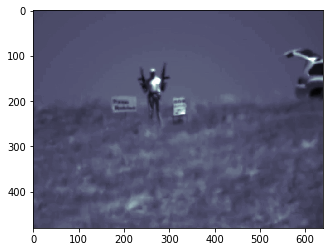

In [16]:
plt.imshow(frames[0],cmap='bone')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_43 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_44 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 480, 640, 1)       290       
_________________________________________________________________
lambda_45 (Lambda)           (None, 480, 640, 1)       0         
Total params: 290
Trainable params: 290
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 266.7329 - val_loss: 224.71

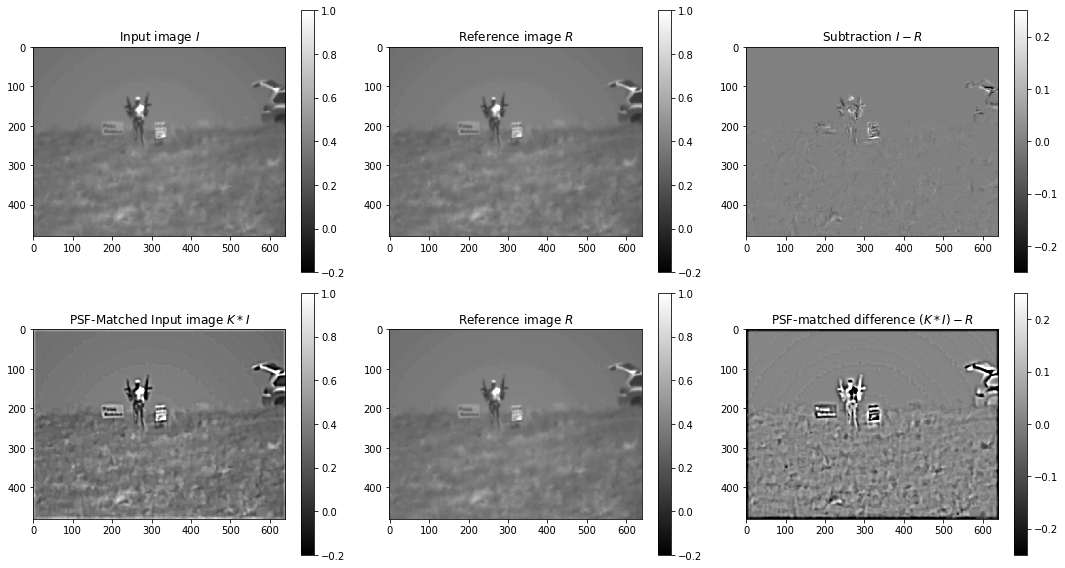

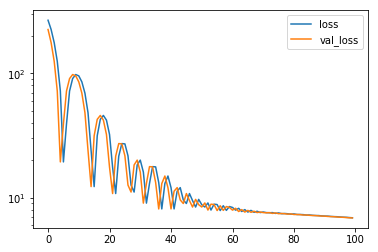

In [75]:
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=17,nsub=1)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=2.e-3,metric='logcosh',epochs=100,verbose=True,
                reduce_patience=0,batch_size=512)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_96 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_97 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 480, 640, 1)       82        
_________________________________________________________________
lambda_98 (Lambda)           (None, 480, 640, 1)       0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 0.3700 - val_loss: 0.3033
cyc

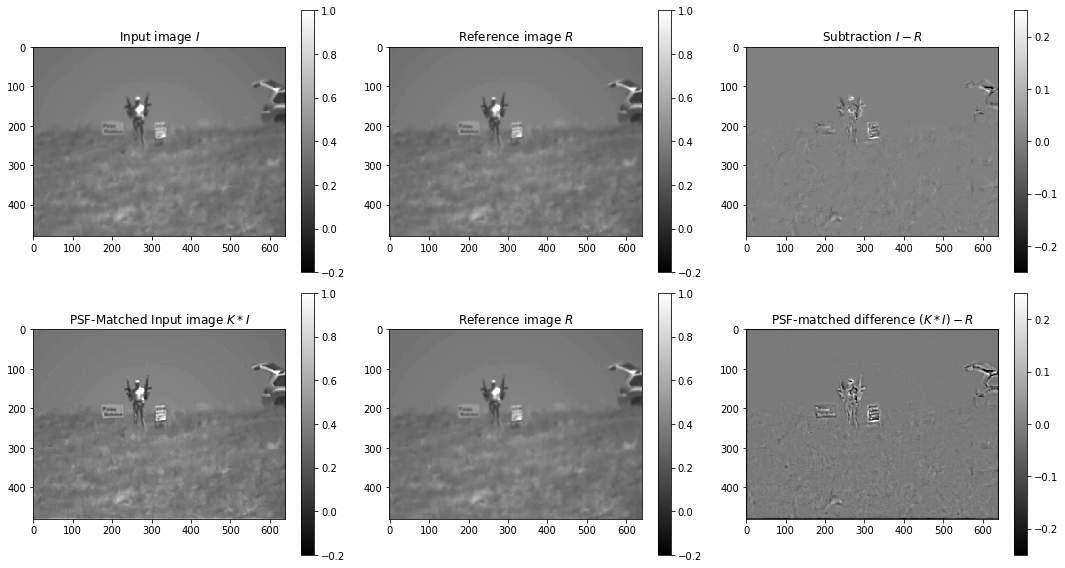

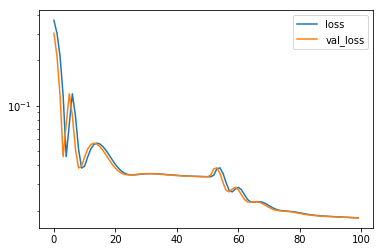

In [107]:
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=1,bias=True)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=1.e-2,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=50,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)

(1.0969719, -0.007437239, 0.9925655)

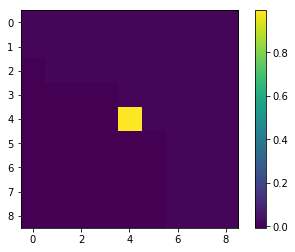

In [61]:
w=model1.get_weights()
k=np.squeeze(w[0])
plt.imshow(k)
plt.colorbar()
k.sum(),k.min(),k.max()

W0717 10:50:45.052479 139956490053504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0717 10:50:45.105155 139956490053504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.

W0717 10:50:45.127441 139956490053504 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_7 (Lambda)            (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_8 (Lambda)            (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 480, 640, 1)       82        
_________________________________________________________________
lambda_9 (Lambda)            (None, 480, 640, 1)       0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 1s 737ms/step - loss: 266.7893 - val_loss: 207.4

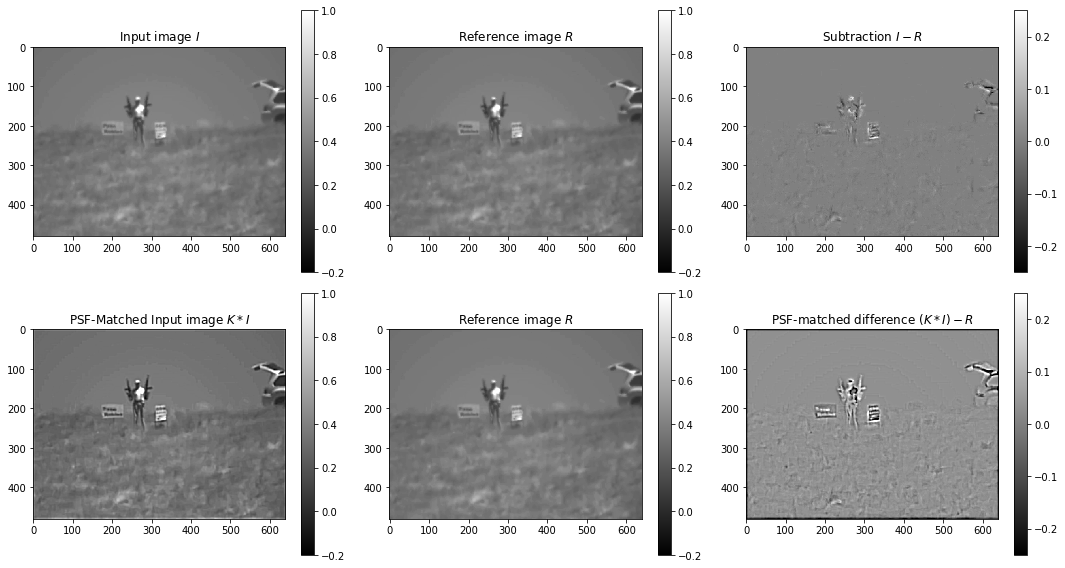

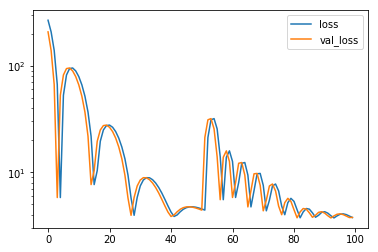

In [13]:
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=1,bias=True)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=1.e-2,min_lr=1.e-4,metric='kmmae',l1=0,epochs=100,verbose=True,
                reduce_patience=50,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)

In [61]:
x.min(),x.max()

(-6.9379635, -6.885411)

In [51]:
norm(inp).min(),norm(inp).max()

(0.0, 1.0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_31 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_32 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 480, 640, 1)       82        
_________________________________________________________________
lambda_33 (Lambda)           (None, 480, 640, 1)       0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.4582 - val_loss: 0.3829
cyc

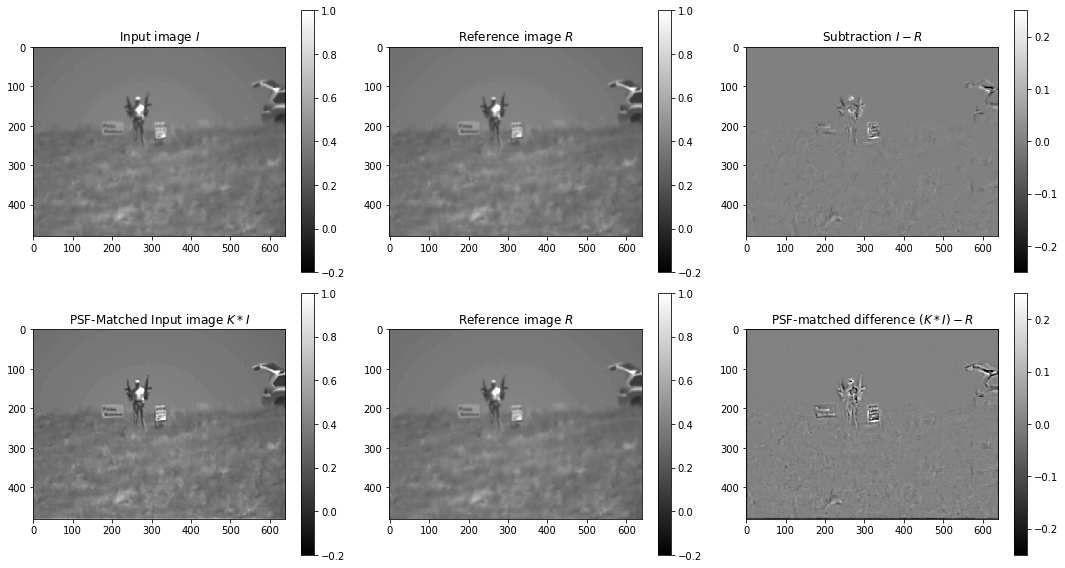

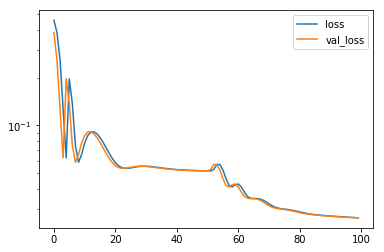

In [28]:
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=1,bias=True)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=1.e-2,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=50,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)
# faster execution and better final value using power_factor=[0.1,0.45,0.45]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_40 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_41 (Lambda)           (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 480, 640, 1)       82        
_________________________________________________________________
lambda_42 (Lambda)           (None, 480, 640, 1)       0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 0.4582 - val_loss: 0.3829
cyc

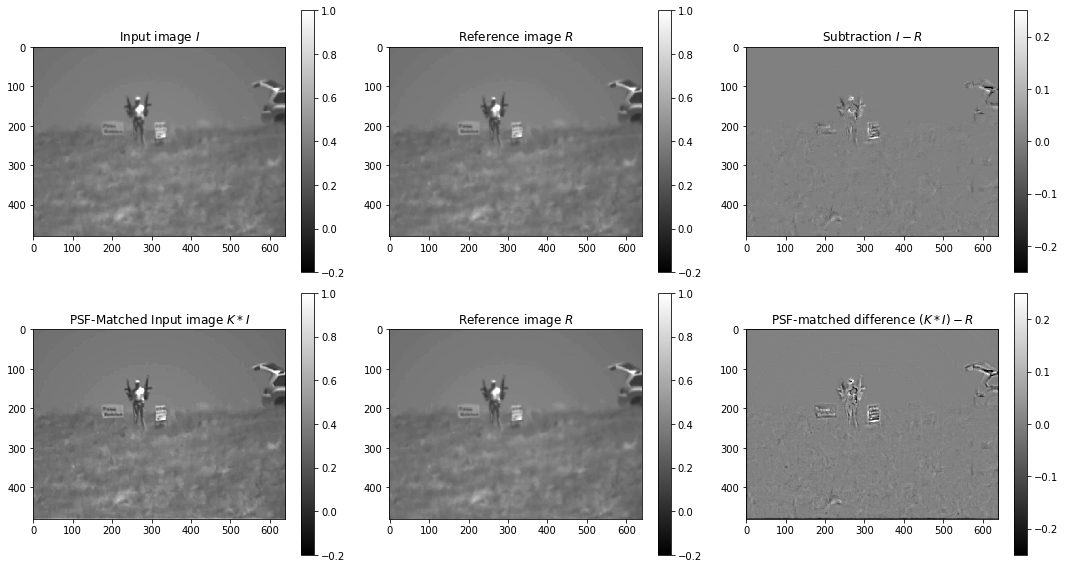

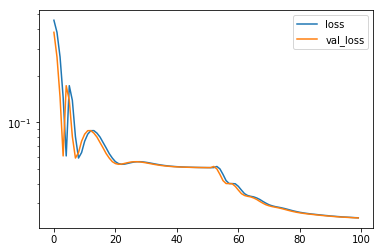

In [34]:
# using dwell=2 and power_factor=[0.1,0.45,0.45]
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=1,bias=True)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=1.e-2,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=50,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_109 (Lambda)          (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_110 (Lambda)          (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 480, 640, 1)       82        
_________________________________________________________________
lambda_111 (Lambda)          (None, 480, 640, 1)       0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 0.0112 - val_loss: 0.0159
cyc

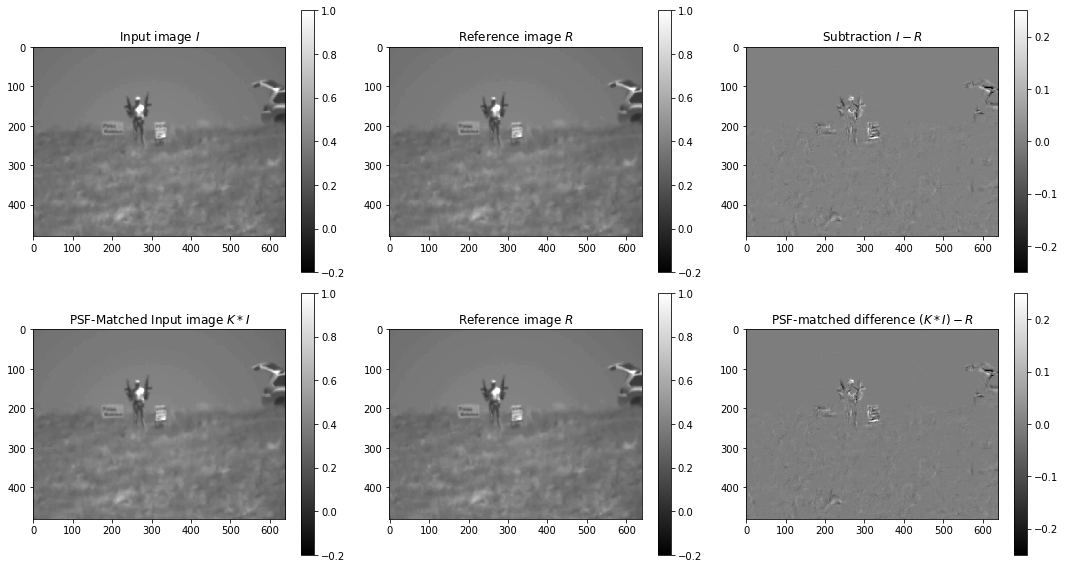

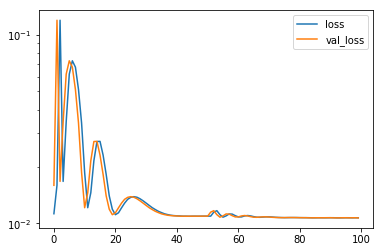

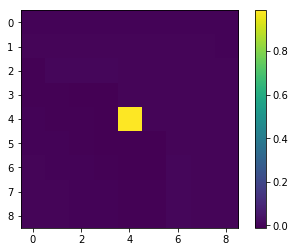

In [69]:
# using dwell=2 and power_factor=[0.1,0.45,0.45], random kinit
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=1,bias=True,kernel_init=False)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=1.e-2,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=50,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_112 (Lambda)          (None, 480, 640, 1)       0         
_________________________________________________________________
lambda_113 (Lambda)          (None, 480, 640, 1)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 480, 640, 1)       82        
_________________________________________________________________
lambda_114 (Lambda)          (None, 480, 640, 1)       0         
Total params: 82
Trainable params: 82
Non-trainable params: 0
_________________________________________________________________
None
Train on 1 samples, validate on 1 samples
Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 0.0112 - val_loss: 0.0110



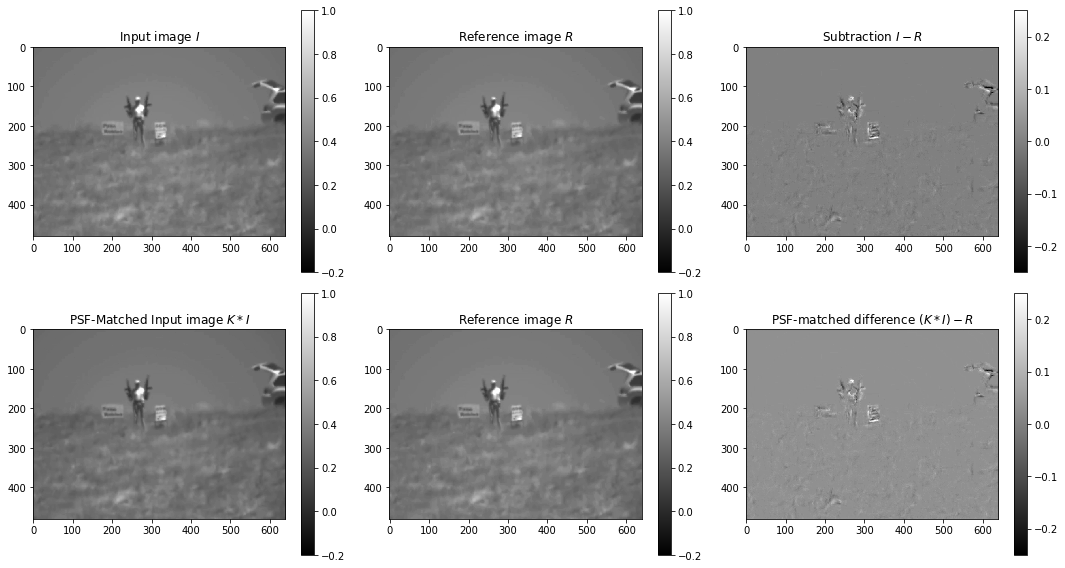

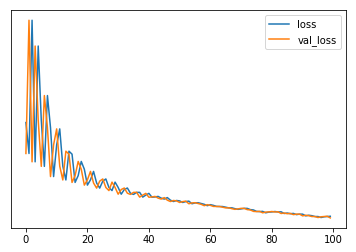

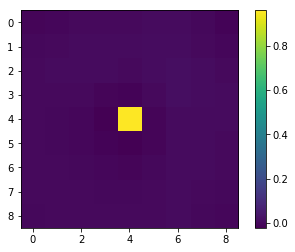

In [70]:
# using patience=0 power_factor=[0.1,0.45,0.45],  kinit=delta
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=1,bias=True,kernel_init=False)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=2.e-3,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=0,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)
# it settled to final value very quickly but because there was really nothing to change.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
lambda_115 (Lambda)             (None, 480, 640, 1)  0           input_31[0][0]                   
__________________________________________________________________________________________________
lambda_116 (Lambda)             (None, 480, 640, 1)  0           lambda_115[0][0]                 
__________________________________________________________________________________________________
lambda_118 (Lambda)             (None, 480, 640, 1)  0           lambda_115[0][0]                 
__________________________________________________________________________________________________
lambda_120

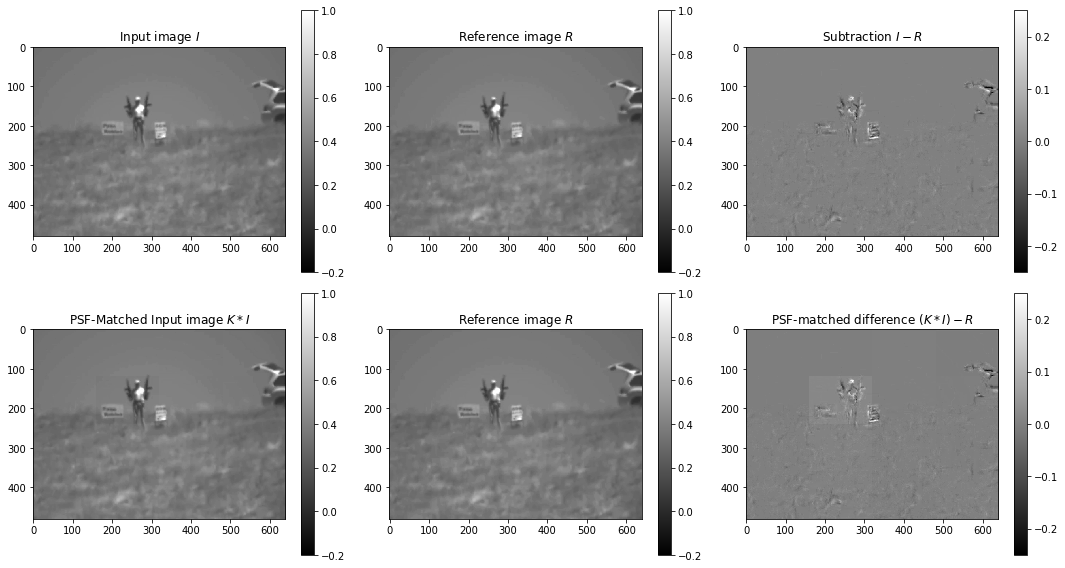

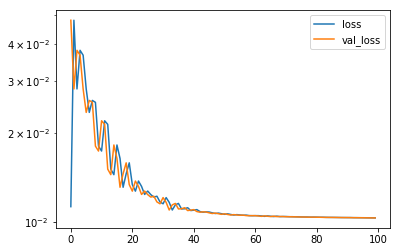

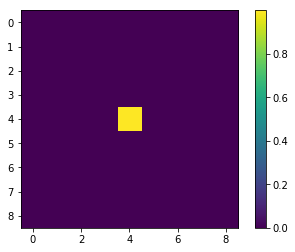

In [71]:
# using patience=0, 4x4 grid, power_factor=[0.1,0.45,0.45], 
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=4,bias=True,kernel_init=False)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=2.e-3,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=0,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)
# it settled to final value very quickly but because there was really nothing to change.

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 480, 640, 1)  0                                            
__________________________________________________________________________________________________
lambda_148 (Lambda)             (None, 480, 640, 1)  0           input_32[0][0]                   
__________________________________________________________________________________________________
lambda_149 (Lambda)             (None, 480, 640, 1)  0           lambda_148[0][0]                 
__________________________________________________________________________________________________
lambda_151 (Lambda)             (None, 480, 640, 1)  0           lambda_148[0][0]                 
__________________________________________________________________________________________________
lambda_153

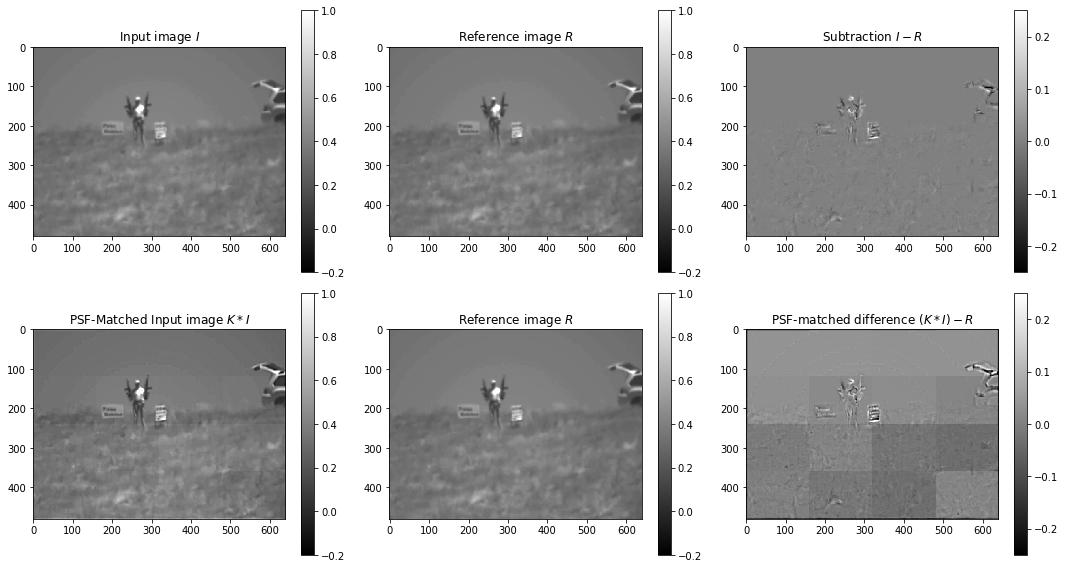

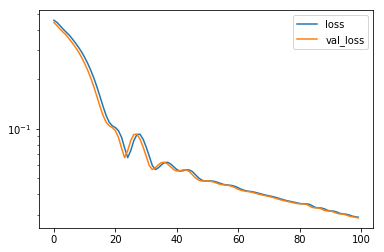

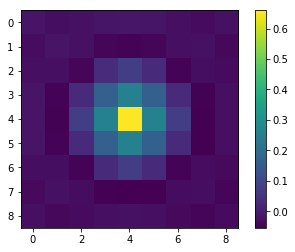

In [72]:
# using patience=0, 4x4 grid, power_factor=[0.1,0.45,0.45], kcube init
inp=frames[1].astype(np.float32)[:,:,np.newaxis]
ref=frames[0].astype(np.float32)[:,:,np.newaxis]
model=psfmatch(inp.shape,mask=None,w=9,nsub=4,bias=True,kernel_init=True)
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=2.e-3,min_lr=1.e-4,metric='ssim',l1=0,epochs=100,verbose=True,
                reduce_patience=0,batch_size=1,decay=10.**-0.25)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)
# it settled to final value very quickly but because there was really nothing to change.

Train on 1 samples, validate on 1 samples
Epoch 1/200
1/1 [==============================] - 8s 8s/step - loss: 0.0287 - val_loss: 0.0284

Epoch 00001: val_loss improved from inf to 0.02836, saving model to /content/gdrive/dip//20190717_1618.hdf5
Epoch 2/200
1/1 [==============================] - 8s 8s/step - loss: 0.0284 - val_loss: 0.0281

Epoch 00002: val_loss improved from 0.02836 to 0.02807, saving model to /content/gdrive/dip//20190717_1618.hdf5
Epoch 3/200
1/1 [==============================] - 8s 8s/step - loss: 0.0281 - val_loss: 0.0279

Epoch 00003: val_loss improved from 0.02807 to 0.02788, saving model to /content/gdrive/dip//20190717_1618.hdf5
Epoch 4/200
1/1 [==============================] - 8s 8s/step - loss: 0.0279 - val_loss: 0.0276

Epoch 00004: val_loss improved from 0.02788 to 0.02765, saving model to /content/gdrive/dip//20190717_1618.hdf5
Epoch 5/200
1/1 [==============================] - 8s 8s/step - loss: 0.0276 - val_loss: 0.0273

Epoch 00005: val_loss improve

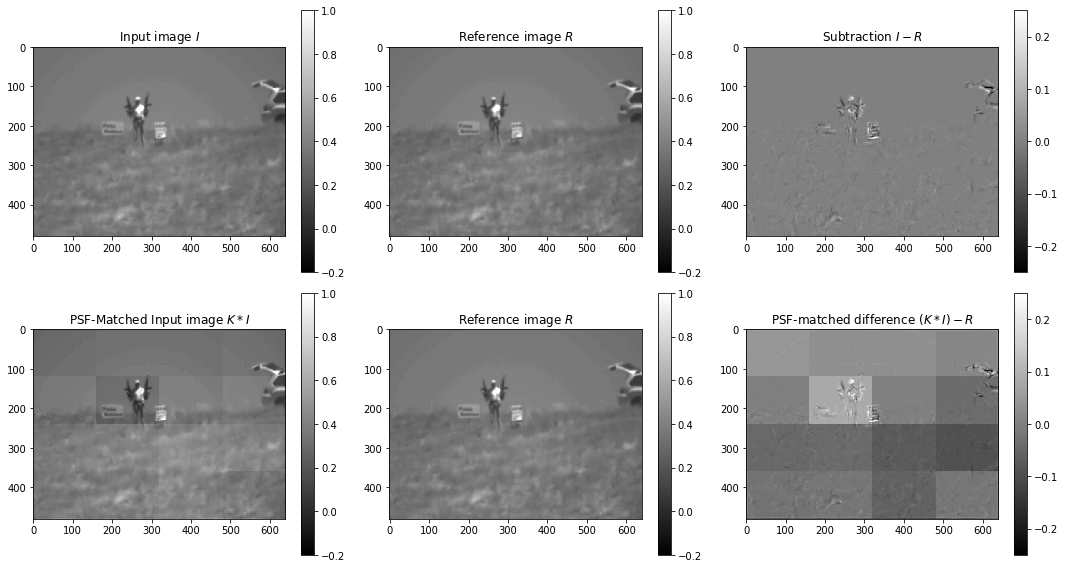

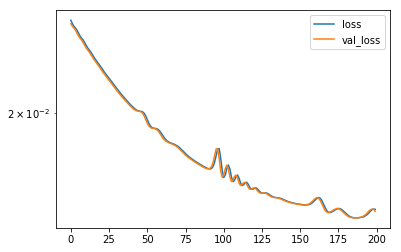

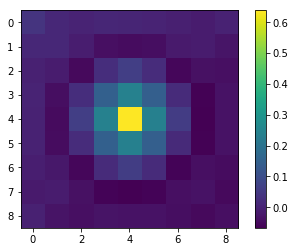

In [73]:
model1=fitModel(model,ref[np.newaxis,...],inp[np.newaxis,...],
          lr=2.e-3,min_lr=1.e-4,metric='ssim',l1=0,epochs=200,verbose=True,
                reduce_patience=0,batch_size=1,warm_start=True)
model1.evaluate(inp[np.newaxis,...],ref[np.newaxis,...])
plot(model1,inp,ref,flip=True)
#